# <center>**An Investigation of Regression Techniques to Predict Housing Prices**</center>

<center>By Brian Hitchcock and Brandon Lasher</center>



---

<center> <img width='70%'  src='https://img.freepik.com/free-vector/cartoon-set-houses-with-garages-white_107791-18938.jpg?w=1800&t=st=1682898965~exp=1682899565~hmac=39c21b19b6603e5e24bd372f3061355d0cfe133e186c1b0ffd24995110fcd20b'></img></center>

**Problem**

House price prediction has been an important area of research and has a practical application in real estate. By understanding the factors that contribute to a property's value we are able to accurately predict its the property's value and it can allow real estate agents, buyers, and sellers to make informed decisions.

In this project, We aim to develop a ML model which can accurately predict the price of properties based on various features. The feature list and their description can be found at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data. The goal is to create a model that can estimate the value of a house based on its characteristics and evalute the quality of the model. We will be creating a Random Forest Regression, A Gradiant Booseter Regression and a Polynomial Linear regression. <br><br><br>



**Results and Conclusion**

<center>

*Regression Type* |    *MAE*     |   *Root MSE* | 	*R2 / EV*
--------------|------------|------------|-------------
LinearRegression           | \~18704.58   | \~28348.17 | \~0.771157
RandomForestRegressor      | \~15613.14 | \~22230.18 | \~0.85946 
GradientBoostingRegressor	 | \~15414.11 | \~21863.97 | \~0.86435 

</center><br><br>

All our models did well, but they also had a fair amount of error in price estimation.  These models have room for improvement, in that the parameters governing their adaptation can be tweaked. The feature set does have redundant features which could be combined, such as square foot of each level of the house and all contribute to the overall square footage.  Upon looking at some of the other submissions for the Kaggle contest, it appears that others had similar results with a .96 EV score being the highest we found among the submissions we inspected.<br><br>
As with any kind of market, things are worth what people are willing to pay and housing is no different. To some a large kitchen is important, to others a large garage. This personal preference will always make prices somewhat subjective and in the end, it is really about fitting the buyer to the house, which will allow the seller to ask for a higher price.  





In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import explained_variance_score as evs
from sklearn.model_selection import train_test_split,cross_val_score

#Allow for inline plotting
%matplotlib inline

In [2]:
# Loading Data
# If this notebook is re-used these need to be modified

from google.colab import drive
drive.mount('/content/drive')

#df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv') # After the model is built this is the data which will be used for testing

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project3/train.csv')
#df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project3/test.csv') # After the model is built this is the data which will be used for testing
df_train.head()


Mounted at /content/drive


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000




---


# Data Cleaning and inspection

In [3]:
#List columns with NA values
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
pd.DataFrame(df_train.isna().sum()).sort_values(by=0,ascending=False).head(20)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


In [4]:
#Find percent of entires which are na
pd.DataFrame(df_train.isna().mean()*100).sort_values(by=0,ascending=False).head(20)

,0
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageCond,5.547945
GarageType,5.547945
GarageFinish,5.547945


In [5]:
#drop any columns which are above 40% bad
df_train_clean = df_train.drop(columns=df_train.columns[df_train.isna().mean() > 0.40])

In [6]:
#Check skew to determine mean or median for na columns
df_train_clean.skew(skipna = True)

<ipython-input-6-96ec2b9820d8>:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train_clean.skew(skipna = True)


Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

In [7]:
#
#Deal with NA values at that are still there
# When:
#  skew value is postiive use mean to fill the missing value.
#  skew value is negative use median to fill the missing value.
#  skew value is zero, use either mean or median to fill the missing value.


df_train_clean['LotFrontage'] = df_train_clean['LotFrontage'].fillna(df_train_clean['LotFrontage'].mean())
df_train_clean['MasVnrArea']  = df_train_clean['MasVnrArea'].fillna(df_train_clean['MasVnrArea'].mean())  
df_train_clean['GarageYrBlt'] = df_train_clean['GarageYrBlt'].fillna(df_train_clean['GarageYrBlt'].median())

In [8]:
#
# Fill in enmerated values, these can not be mean or median
#
df_train_clean['MasVnrType']   = df_train_clean['MasVnrType'].fillna(df_train_clean['MasVnrType'].mode()[0])  
df_train_clean['BsmtQual']     = df_train_clean['BsmtQual'].fillna(df_train_clean['BsmtQual'].mode()[0])  
df_train_clean['BsmtCond']     = df_train_clean['BsmtCond'].fillna(df_train_clean['BsmtCond'].mode()[0])  
df_train_clean['BsmtExposure'] = df_train_clean['BsmtExposure'].fillna(df_train_clean['BsmtExposure'].mode()[0])  
df_train_clean['BsmtFinType1'] = df_train_clean['BsmtFinType1'].fillna(df_train_clean['BsmtFinType1'].mode()[0])  
df_train_clean['BsmtFinType2'] = df_train_clean['BsmtFinType2'].fillna(df_train_clean['BsmtFinType2'].mode()[0])  
df_train_clean['Electrical']   = df_train_clean['Electrical'].fillna(df_train_clean['Electrical'].mode()[0])  
df_train_clean['GarageType']   = df_train_clean['GarageType'].fillna(df_train_clean['GarageType'].mode()[0])  
df_train_clean['GarageFinish'] = df_train_clean['GarageFinish'].fillna(df_train_clean['GarageFinish'].mode()[0]) 
df_train_clean['GarageQual']   = df_train_clean['GarageQual'].fillna(df_train_clean['GarageQual'].mode()[0])  
df_train_clean['GarageCond']   = df_train_clean['GarageCond'].fillna(df_train_clean['GarageCond'].mode()[0])  

In [9]:
df_train_clean.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [10]:
#Get a rough idea of what correlations 
# Will dive deeper into this when we clean the data
(df_train_clean.corr()['SalePrice']*100).sort_values(ascending=False)

<ipython-input-10-b322cba5289c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df_train_clean.corr()['SalePrice']*100).sort_values(ascending=False)


SalePrice        100.000000
OverallQual       79.098160
GrLivArea         70.862448
GarageCars        64.040920
GarageArea        62.343144
TotalBsmtSF       61.358055
1stFlrSF          60.585218
FullBath          56.066376
TotRmsAbvGrd      53.372316
YearBuilt         52.289733
YearRemodAdd      50.710097
MasVnrArea        47.524132
Fireplaces        46.692884
GarageYrBlt       46.675365
BsmtFinSF1        38.641981
LotFrontage       33.490085
WoodDeckSF        32.441344
2ndFlrSF          31.933380
OpenPorchSF       31.585623
HalfBath          28.410768
LotArea           26.384335
BsmtFullBath      22.712223
BsmtUnfSF         21.447911
BedroomAbvGr      16.821315
ScreenPorch       11.144657
PoolArea           9.240355
MoSold             4.643225
3SsnPorch          4.458367
BsmtFinSF2        -1.137812
BsmtHalfBath      -1.684415
MiscVal           -2.118958
Id                -2.191672
LowQualFinSF      -2.560613
YrSold            -2.892259
OverallCond       -7.785589
MSSubClass        -8

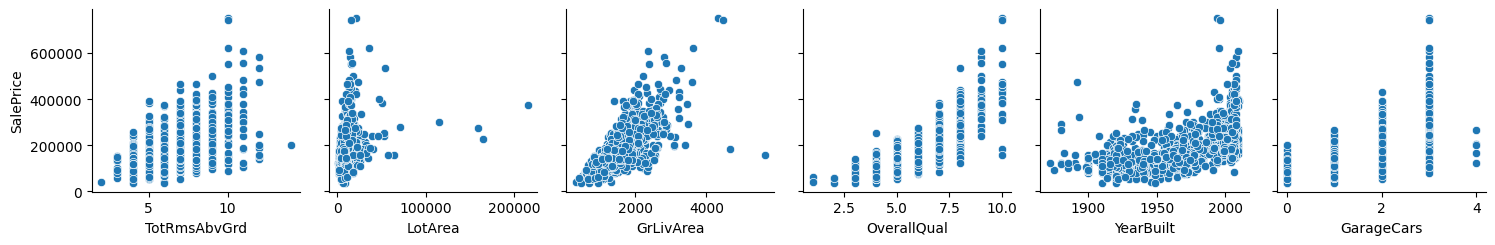

In [11]:
#Plot some of the possible correlated features, to see trends
g = sns.PairGrid(df_train_clean, x_vars=['TotRmsAbvGrd', 'LotArea', 'GrLivArea', 'OverallQual', 'YearBuilt','GarageCars'], y_vars='SalePrice')    
g = g.map(sns.scatterplot)
plt.show()

In [12]:
# We need to remove any outliners for the target saleprice
#  to help trian this data

# The IQR (Interquartile Range) method is a way for handling outliers in data 
#  that has an abnormal distribution. This method uses the distance between the 
#  first quartile and the third quartile as a measure of the distance
#  between the outlier data and the median value in the dataset.

def limit(data, var):    
    iqr = data[var].quantile(0.75) - data[var].quantile(0.25)
    
    lower_limit = data[var].quantile(0.25) - (iqr*1.5)
    upper_limit = data[var].quantile(0.75) + (iqr*1.5)
    
    return lower_limit, upper_limit


lower_sale, upper_sale = limit(df_train_clean, 'SalePrice')

df_train_clean_noOut = df_train_clean[(df_train_clean.SalePrice > lower_sale)&(df_train_clean.SalePrice < upper_sale)]

print( f"Number of outliers removed: {df_train_clean.shape[0] - df_train_clean_noOut.shape[0]}")

Number of outliers removed: 61




---


# Feature selection

In [13]:
#Isolate numberical features vs categorical features
numer_columns = df_train_clean_noOut.select_dtypes(include=np.number).columns.tolist()
cate_columns = df_train_clean_noOut.select_dtypes(include= ['object']).columns.tolist()

train_numer = df_train_clean_noOut[numer_columns]
train_cate = df_train_clean_noOut[cate_columns]

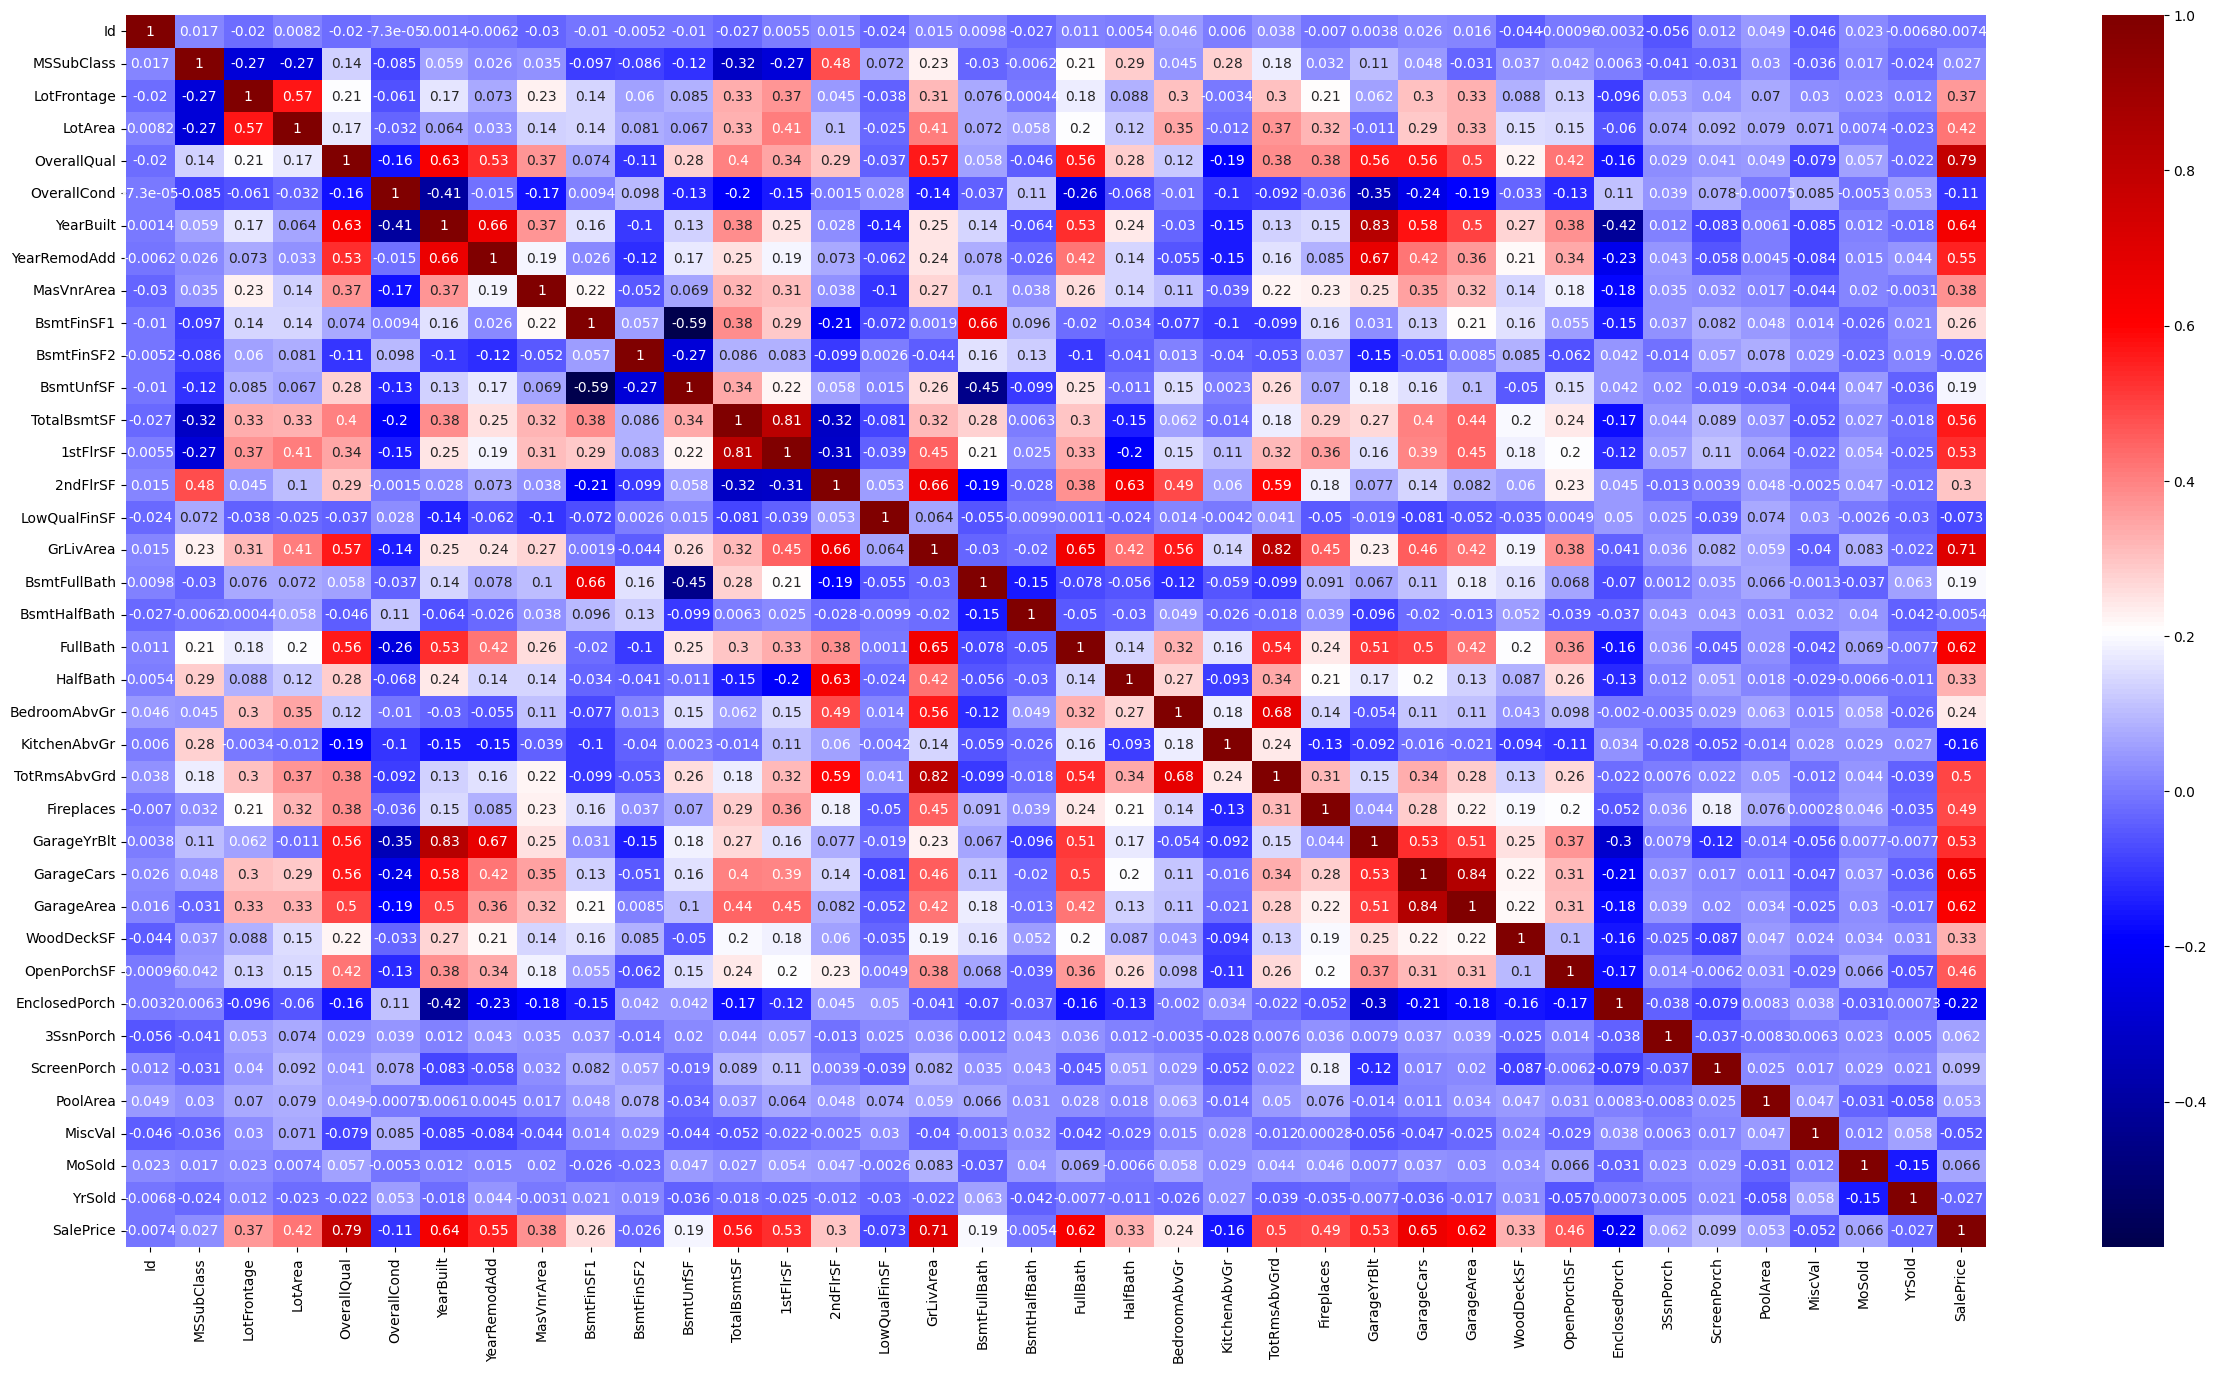

In [14]:
#Plot heat map of numerical 
plt.figure(figsize=(30,16))
sns.heatmap(train_numer.corr(method = 'spearman'), annot=True, cmap='seismic')
plt.show()

In [15]:
#List the correlation of the numberical features 
(train_numer.corr()['SalePrice']*100).sort_values(ascending=False)

SalePrice        100.000000
OverallQual       78.429431
GrLivArea         66.132457
GarageCars        62.801307
GarageArea        60.722962
FullBath          57.736866
YearBuilt         56.455801
TotalBsmtSF       54.350839
YearRemodAdd      54.116060
1stFlrSF          52.278499
GarageYrBlt       47.578141
TotRmsAbvGrd      47.229206
Fireplaces        45.300976
MasVnrArea        35.266647
OpenPorchSF       32.579073
2ndFlrSF          31.735811
WoodDeckSF        30.233863
LotFrontage       29.703460
BsmtFinSF1        29.037668
HalfBath          27.883055
LotArea           24.981193
BsmtUnfSF         22.279549
BsmtFullBath      20.218500
BedroomAbvGr      20.161016
ScreenPorch       10.885107
MoSold             7.047782
PoolArea           4.868221
3SsnPorch          4.332370
BsmtFinSF2         0.715426
Id                -1.198390
MiscVal           -1.287187
BsmtHalfBath      -1.882673
YrSold            -2.824535
OverallCond       -4.800544
LowQualFinSF      -5.808636
MSSubClass        -6

## Encode Catagorical features

In [16]:
train_cate.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [17]:
# Encode the categorical data
oe= OrdinalEncoder()
cat = oe.fit_transform(train_cate)
#Put back into dataframe
train_cate_enc = pd.DataFrame(cat, columns=train_cate.columns)
train_cate_enc.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,3.0,1.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,...,4.0,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,3.0,1.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,3.0,1.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,...,4.0,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,3.0,1.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,...,4.0,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0


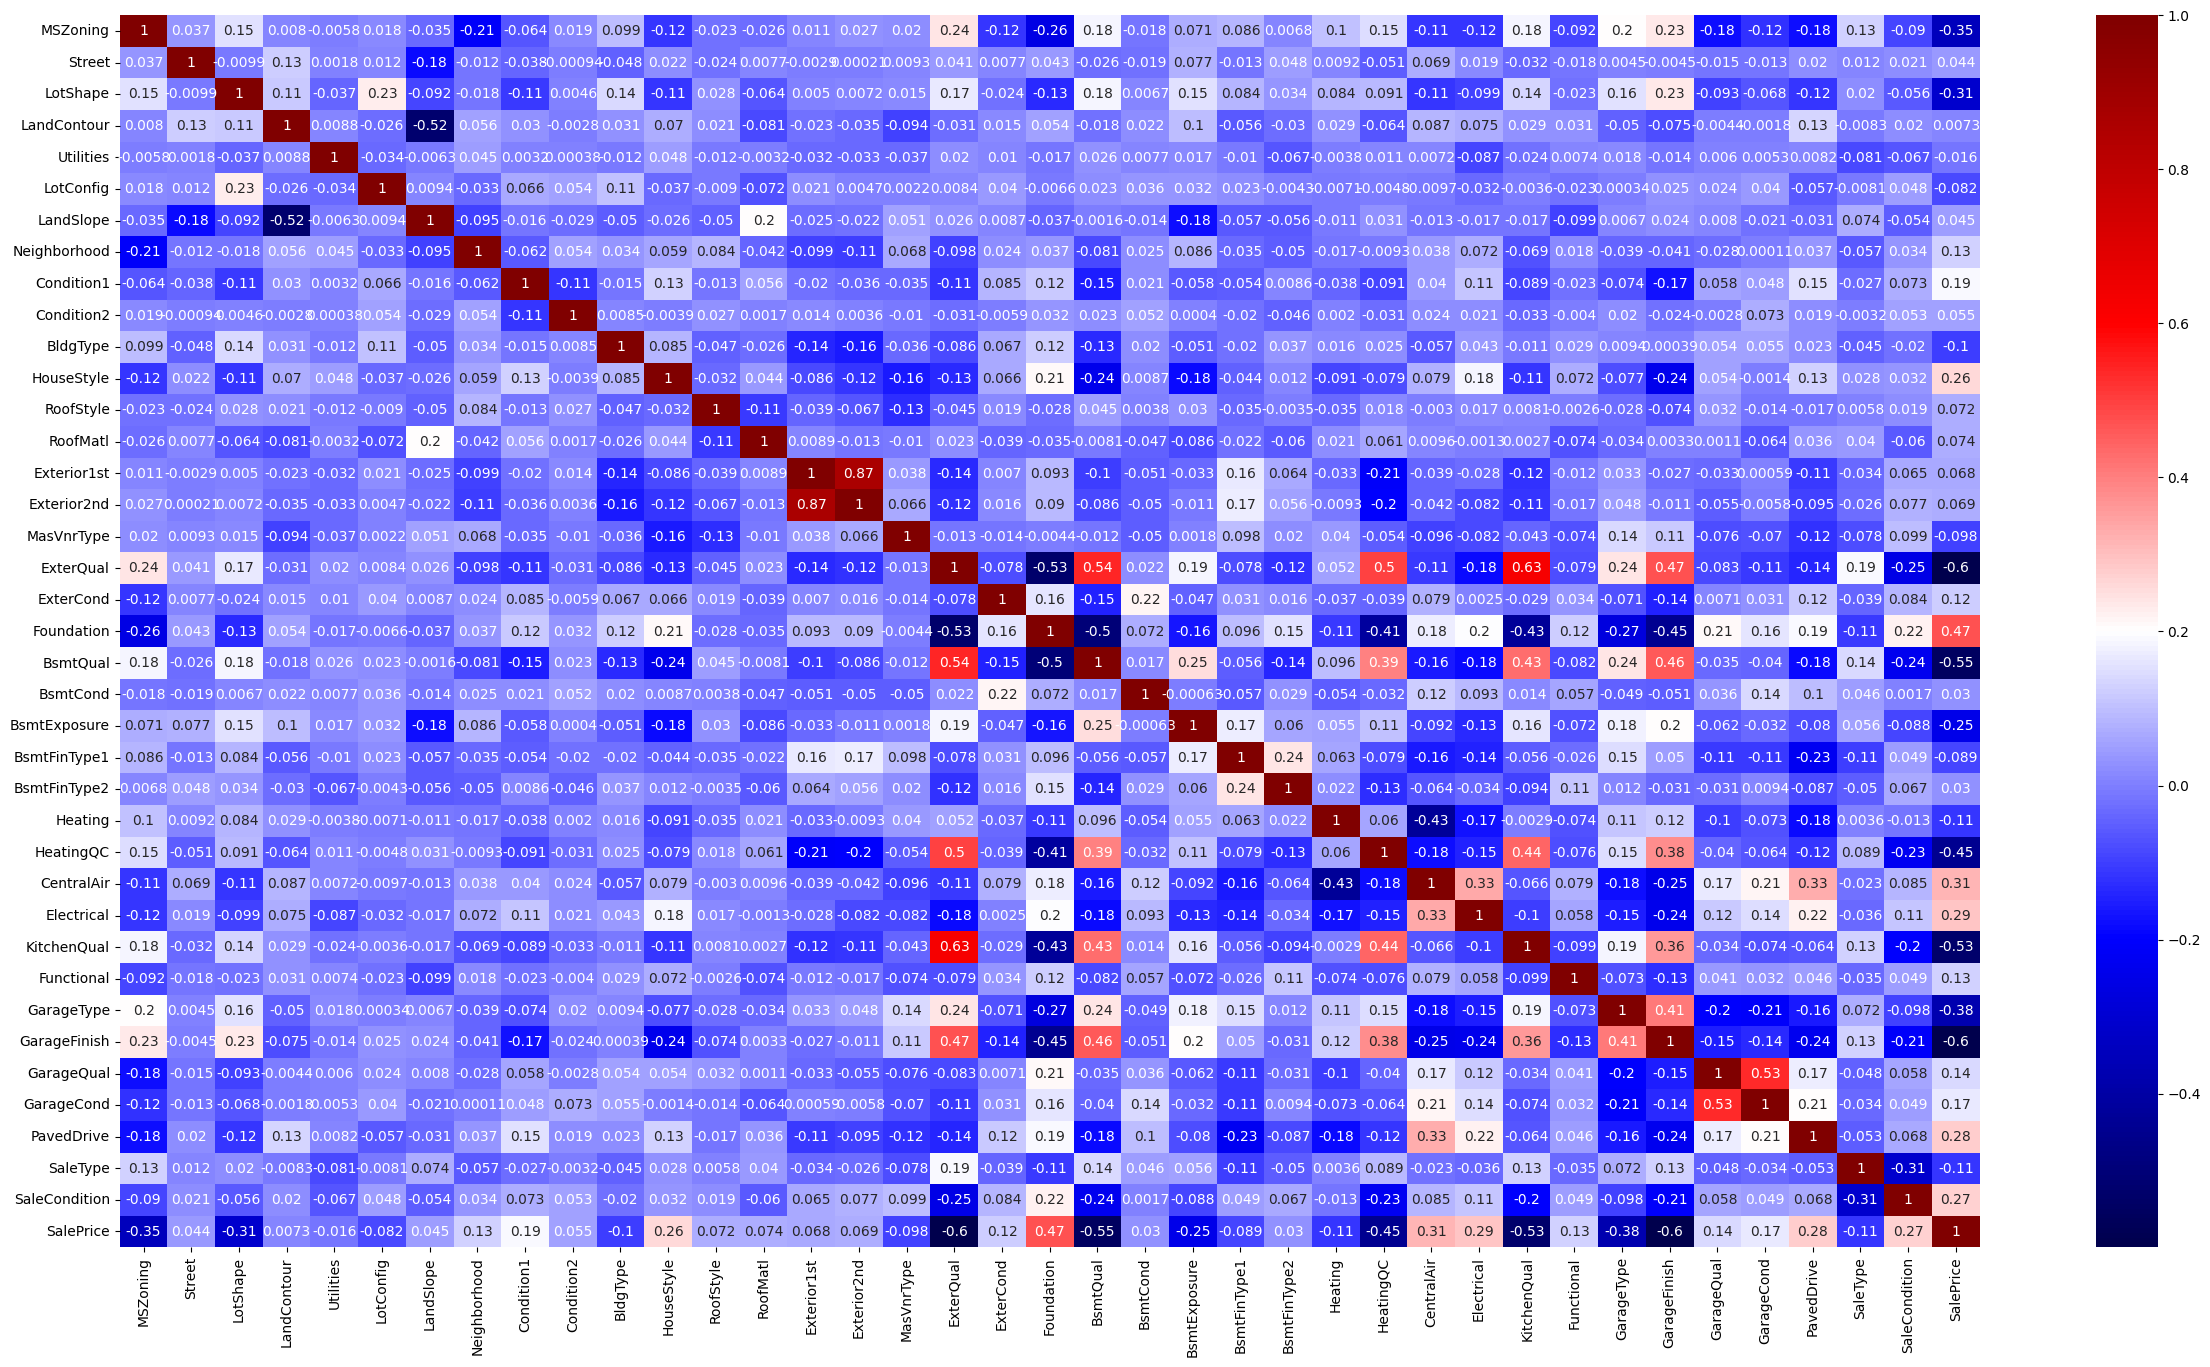

In [18]:
#Add SalePrice and then plot heat map

#Note I had an issue with assigning here, the indexing would mismatch. I had to 
# convert the clean, to a numpy array
train_cate_enc['SalePrice'] = df_train_clean_noOut['SalePrice'].to_numpy()
plt.figure(figsize=(30,16))
sns.heatmap(train_cate_enc.corr(method = 'spearman'), annot=True, cmap='seismic')
plt.show()

In [19]:
#List out correlations of categorical features
(train_cate_enc.corr(method = 'spearman')['SalePrice']*100).sort_values(ascending=False)

SalePrice        100.000000
Foundation        47.402608
CentralAir        31.412189
Electrical        29.198416
PavedDrive        27.666618
SaleCondition     27.006789
HouseStyle        26.199275
Condition1        18.890390
GarageCond        16.764506
GarageQual        13.806369
Neighborhood      12.893884
Functional        12.889864
ExterCond         12.484319
RoofMatl           7.381102
RoofStyle          7.173816
Exterior2nd        6.927691
Exterior1st        6.771599
Condition2         5.471580
LandSlope          4.542001
Street             4.389097
BsmtFinType2       3.025599
BsmtCond           3.019515
LandContour        0.726375
Utilities         -1.579473
LotConfig         -8.221699
BsmtFinType1      -8.881545
MasVnrType        -9.820295
BldgType         -10.131836
Heating          -11.253326
SaleType         -11.280618
BsmtExposure     -24.500278
LotShape         -30.664669
MSZoning         -34.620206
GarageType       -37.727618
HeatingQC        -44.877529
KitchenQual      -52


Now that we have an idea of correlation scores, we can set a threshold at which a feature must correlate with the target inorder for us to use it.

In [56]:
#Output sizes to show changes in number of columns

print( "Shape before pruning: ")
print( f"train_numer: {train_numer.shape}, train_cate_enc: {train_cate_enc.shape}" )

#Changing this will effect the overall output
corrThresh = .30;

train_numer = train_numer.loc[:,  (train_numer.corr()['SalePrice'] > corrThresh) | (train_numer.corr()['SalePrice'] < -corrThresh) ]
train_cate_enc = train_cate_enc.loc[:,  (train_cate_enc.corr()['SalePrice'] > corrThresh) | (train_cate_enc.corr()['SalePrice'] < -corrThresh) ]

print( "Shape after pruning: ")
print( f"train_numer: {train_numer.shape}, train_cate_enc: {train_cate_enc.shape}" )


Shape before pruning: 
train_numer: (1399, 17), train_cate_enc: (1399, 8)
Shape after pruning: 
train_numer: (1399, 17), train_cate_enc: (1399, 8)


In [57]:
print( "Columns selected for each: " )
print( train_numer.columns )
print( train_cate_enc.columns )

Columns selected for each: 
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'SalePrice'],
      dtype='object')
Index(['ExterQual', 'Foundation', 'BsmtQual', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'SalePrice'],
      dtype='object')


In [58]:
#Create initial data train set
y = df_train_clean_noOut['SalePrice']
X = pd.concat([train_numer.drop(columns='SalePrice').reset_index(drop=True), train_cate_enc.drop(columns='SalePrice').reset_index(drop=True)], axis=1)



---


# Model Creation

In [59]:
#Create and scale teh data sets for random forest regression

#Make sure all input is properly scaled
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=1001) # Use small test size as I have an addional test 

### Random Forest Regession

In [60]:
#Create regressor and train
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
#Run predictions
rf_pred = rf.predict(X_test)

In [61]:
#Format prediction vs actual 
df_comp = pd.DataFrame(rf_pred, columns=['prediction'])
comparison_rf = pd.concat([y_test.reset_index(drop=True),df_comp], axis=1)
comparison_rf.head(10)

,SalePrice,prediction
0,137000,123974.80
1,274900,295608.28
2,213000,227243.66
3,55000,92828.00
4,141000,147349.50
5,173000,163303.62
6,112000,152625.33
7,144000,173265.50
8,244600,253366.55
9,336000,292398.54


In [62]:
mae = mean_absolute_error(y_test, rf_pred)
ev = evs(y_test, rf_pred)
mse = mean_squared_error(y_test, rf_pred)

print(f"MAE: {mae}")
print(f"rMSE: {np.sqrt(mse)}")
print(f"ev: {ev}")

MAE: 15613.135102380955
rMSE: 22230.176896536006
ev: 0.8594604867664504


The random forest regession had an ~88% explained variance score and about a 14.6k mean absolute error. 

### Gradient Boosting Regressor 

In [63]:
#Create regressor and train
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
#run predictions
gb_pred = gb.predict(X_test)

#Format prediction vs actual 
df_comp = pd.DataFrame(gb_pred, columns=['prediction'])
comparison_gb = pd.concat([y_test.reset_index(drop=True),df_comp], axis=1)
comparison_gb.head(10)

,SalePrice,prediction
0,137000,128429.545582
1,274900,292108.839587
2,213000,227065.438052
3,55000,80271.069679
4,141000,147904.261699
5,173000,153536.999983
6,112000,143737.929818
7,144000,156039.796102
8,244600,255883.277047
9,336000,286113.755103


In [64]:
mae = mean_absolute_error(y_test, gb_pred)
ev = evs(y_test, gb_pred)
mse = mean_squared_error(y_test, gb_pred)

print(f"MAE: {mae}")
print(f"rMSE: {np.sqrt(mse)}")
print(f"ev: {ev}")


MAE: 15414.110672017801
rMSE: 21863.970064152334
ev: 0.8643500237248247


The Gradient Boosting regession had an ~89% explained variance score and about a 13.8k mean absolute error. This was the best out of the methods we tested.

### Linear Regression

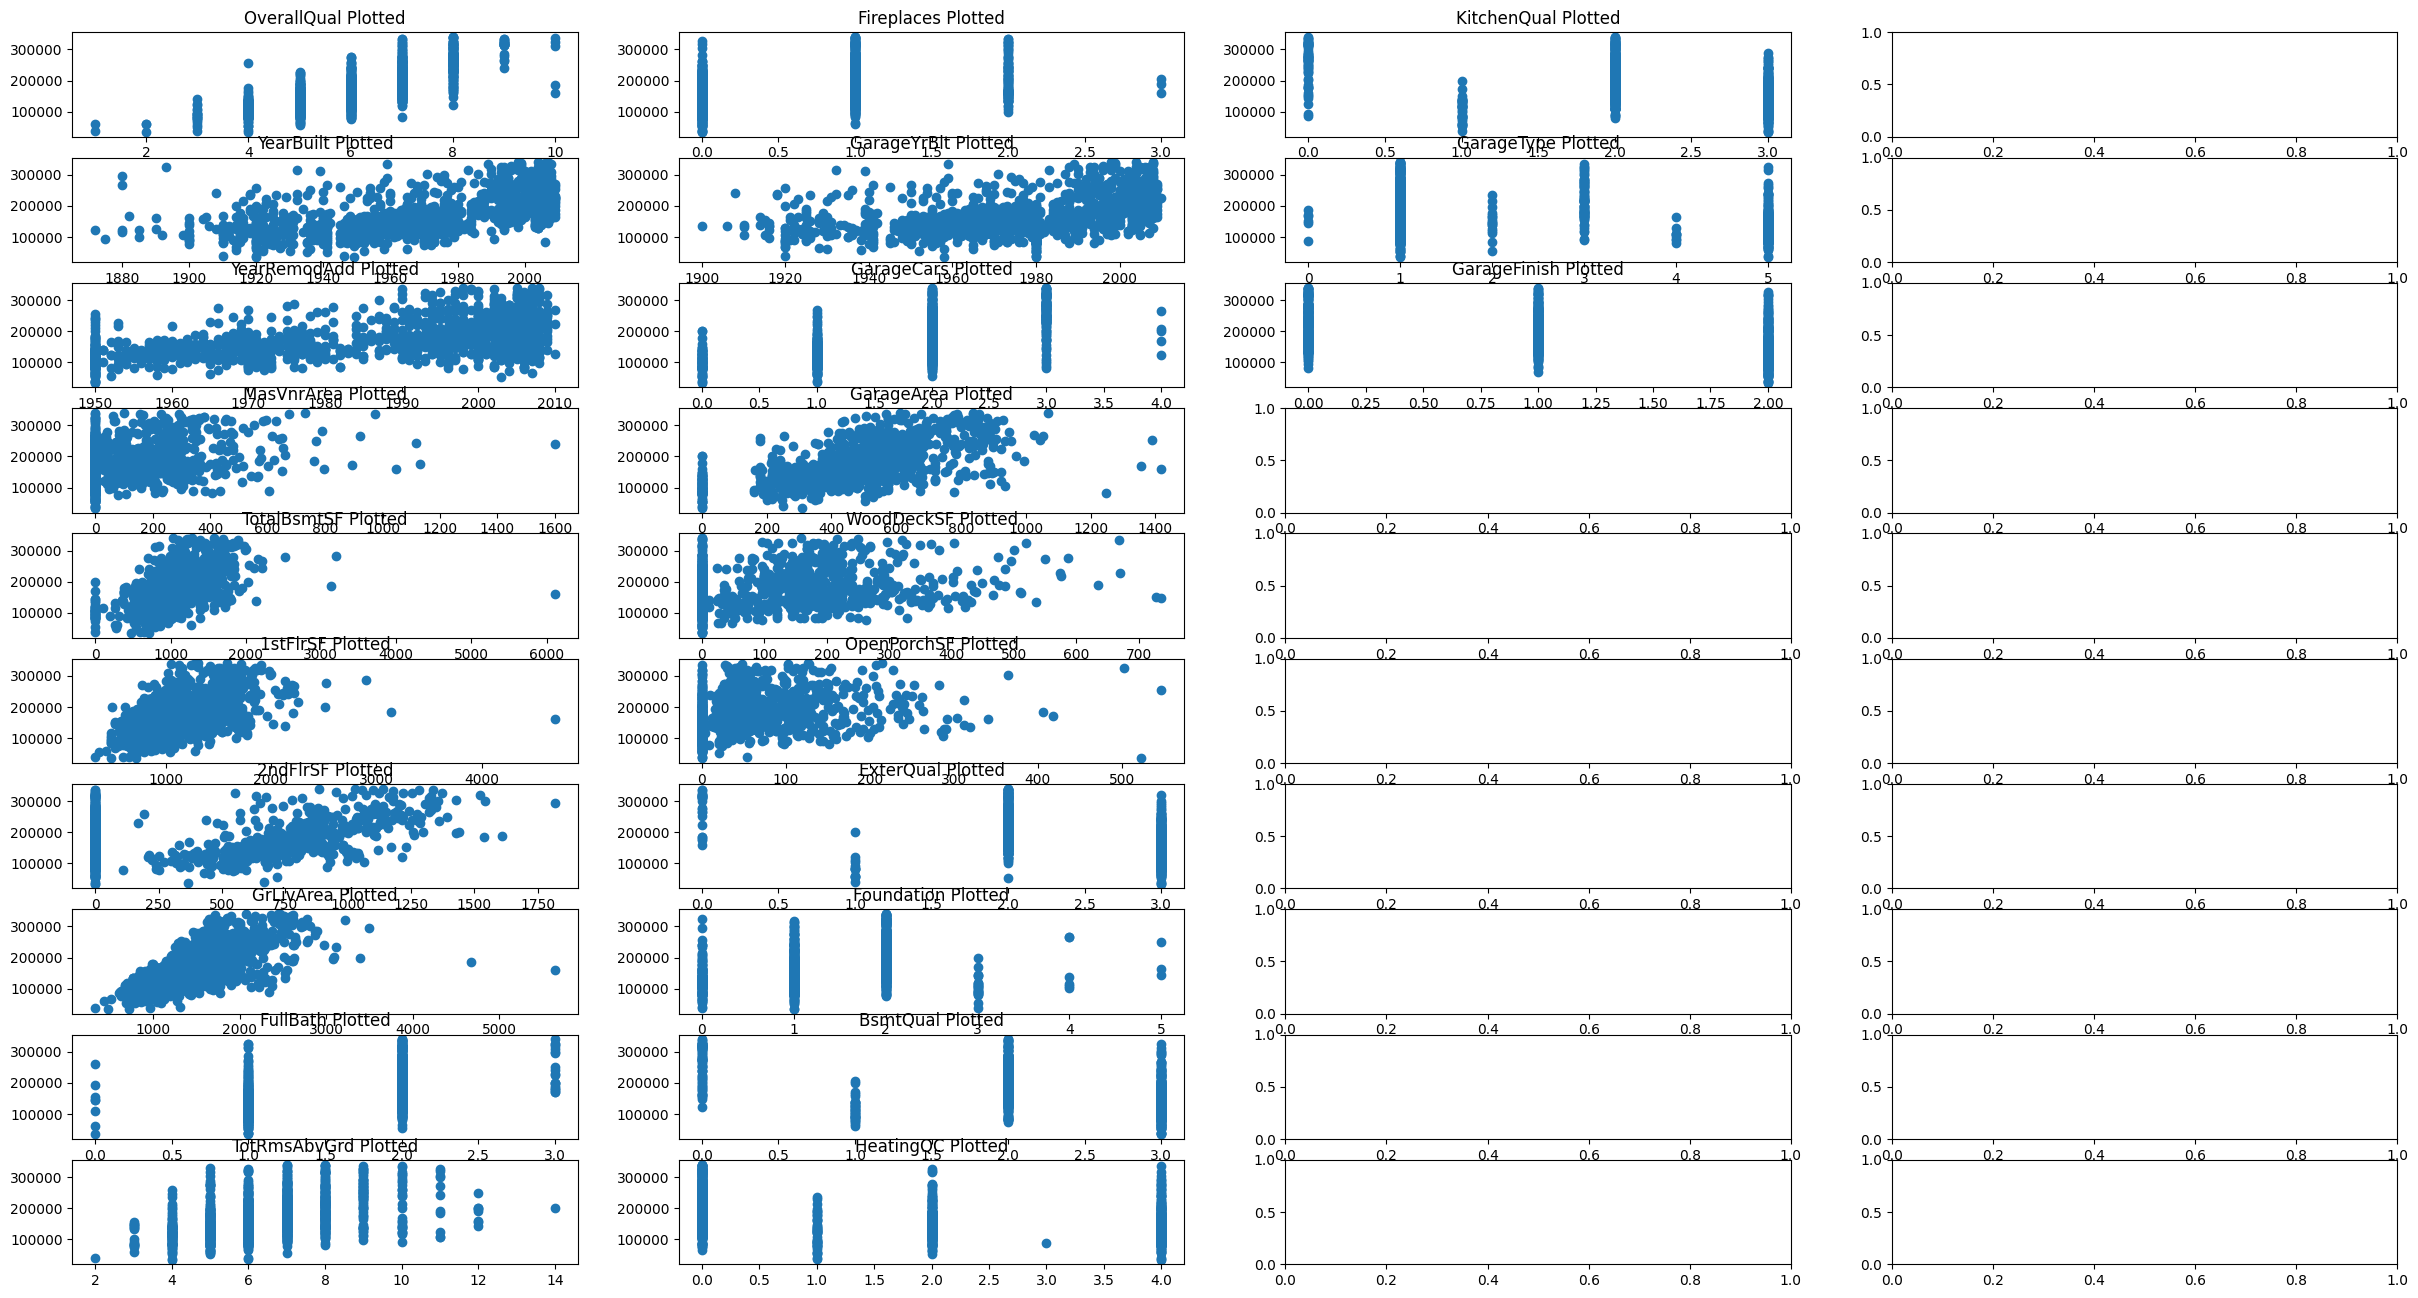

In [65]:
countR = 0;
countC = 0;
count = 0

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(30,16))
for (colname, colval) in X.items():
  row = countR % 10
  col = countC % 4

  axes[row][col].scatter(X[colname], y)
  axes[row][col].set_title( colname + " Plotted")

  countR = countR + 1;
  count = count + 1
  if(count % 10== 0):
    countC = countC + 1;

plt.show()

In [66]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

LinearRegression()

In [67]:
poly_reg_y_predicted = poly_reg_model.predict(X_test)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
poly_r2_score  = r2_score(y_test, poly_reg_y_predicted)

print( f'MAE: {mean_absolute_error(y_test, poly_reg_y_predicted)}' )
print( f'rMSE: {poly_reg_rmse}' )
print( f'r2: {poly_r2_score}' )



MAE: 18704.577499952407
rMSE: 28348.171320161167
r2: 0.7711573111010801
